In [53]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import math

In [54]:
# environment information
track_len = 10000 # m

# place cell information
rho_p = 20/2 # place cell density 
# 1/rho_p is the average distance between two place cells
n_p = int(rho_p * track_len) # number of place cells
print('number of place cells:', n_p)
print('Place cell interval:', track_len/n_p)
a_p = 0.4 # place cell width
print('place cell width:', a_p)
# grid cell information
rho_g = 20/2 # grid cell density
n_g = int(rho_g * 2 * math.pi)
rho_g = n_g / (2 * math.pi) # grid cell density
n_module = 4 # number of modules
n_gs = [n_g] * n_module # number of grid cells in each module
print('number of grid cells in each module:', n_gs)
print('Grid cell interval', 2 * math.pi/n_g)
# first method to set the grid spacing, using irrational number
# lambda_gs = [1., 1/math.sqrt(2), 1/2, 1/(2*math.sqrt(2))] # grid spacing
# second method to set the grid spacing, using rational number
lambda_gs = [23, 14, 8, 5] # grid spacing
lambda_gs = torch.tensor(lambda_gs)
print('grid spacing:', lambda_gs)
lambda_gs_star = lambda_gs/ (2*math.pi)   # normalized grid spacing
print('normalized grid spacing:', lambda_gs_star)
# two ways to set the width of grid cell width
# first method: set the width of grid cell to be the same as place cell
# a_gs = [a_p] * n_module
# print('grid cell width by first method:', a_gs)
# second method: a_gs = a_p / lambda_gs_star
a_gs = a_p / lambda_gs_star
print('grid cell width by second method:', a_gs)


number of place cells: 12800
place cell width: 0.025
number of grid cells in each module: [402, 402, 402, 402]
grid spacing: tensor([1.0000, 0.7071, 0.5000, 0.3536])
normalized grid spacing: tensor([0.1592, 0.1125, 0.0796, 0.0563])
grid cell width by second method: tensor([0.1571, 0.2221, 0.3142, 0.4443])


In [55]:
# Place cell
class PlaceCell(nn.Module):
    def __init__(self, n_p, a_p, track_len):
        super(PlaceCell, self).__init__()
        self.n_p = n_p
        self.a_p = a_p
        self.track_len = track_len
        # self.mu_p = torch.linspace(0, track_len, n_p+1)[:-1]
        # uniformly distributed place cells
        self.mu_p = torch.linspace(0, track_len, n_p+1)[:-1] + 0.5 * track_len / n_p

    def forward(self, x):
        # get postion x, get the activation of place cells
        # x is a scalar for position
        # calculate the activation of place cells
        activation = torch.exp(-0.5 * (x - self.mu_p)**2 / self.a_p**2)
        return activation

PlaceCellModel = PlaceCell(n_p, a_p, track_len)



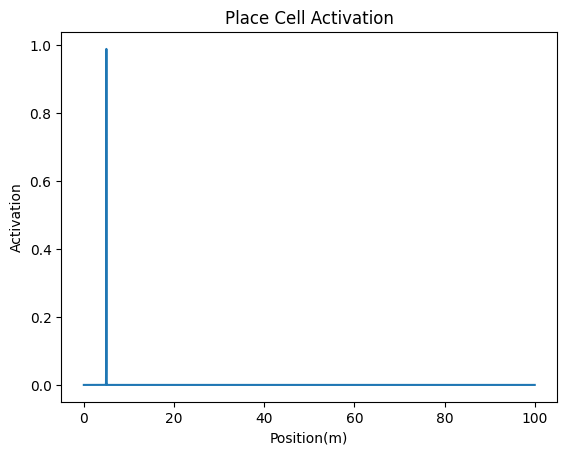

In [56]:
# test place cell
x = torch.tensor([5.])
activation = PlaceCellModel(x)
mu_p = PlaceCellModel.mu_p
plt.figure()
plt.plot(mu_p.detach().numpy(), activation.detach().numpy())
plt.title('Place Cell Activation')
plt.xlabel('Position(m)')
plt.ylabel('Activation')
plt.show()

In [57]:
# Grid cell
class GridCellModules(nn.Module):
    def __init__(self, n_g, n_module, a_gs, lambda_gs,lambda_gs_star, track_len):
        super(GridCellModules, self).__init__()
        self.n_g = n_g
        self.n_module = n_module
        self.n_g_all = n_g * n_module
        self.a_gs = a_gs
        self.lambda_gs = lambda_gs
        self.lambda_gs_star = lambda_gs_star # lambda_gs_star = 1/ (2*math.pi) * lambda_gs
        self.track_len = track_len
        self.phase_len = 2 * math.pi
        self.mu_g = torch.linspace(0, self.phase_len, n_g + 1)[:-1] + 0.5 * self.phase_len / n_g

    def dist(self, d):
        d = abs(d)
        d = torch.where(d>math.pi,2*math.pi-d, d)
        return d

    def forward(self, x):
        # get postion x, get the activation of grid cells
        # calculate the activation of grid cells
        activation = torch.zeros(self.n_g_all)
        for i in range(n_module):
            phase = torch.fmod(x / self.lambda_gs_star[i], self.phase_len)
            distance = self.dist(phase - self.mu_g)
            activation[i*self.n_g:(i+1)*self.n_g] = torch.exp(-0.5 * distance**2 / self.a_gs[i]**2)
        return activation
    

GridCellModel = GridCellModules(n_g, n_module, a_gs, lambda_gs, lambda_gs_star, track_len)



In [58]:
# # test grid cell
# x = torch.tensor([5.])
# activation = GridCellModel(x)
# mu_g = GridCellModel.mu_g
# # 2 * 2 subplot for 4 modules
# fig, axs = plt.subplots(2, 2, figsize=(10, 10))
# for i in range(n_module):
#     ax = axs[i//2, i%2]
#     ax.plot(mu_g.detach().numpy(),activation[i*n_g:(i+1)*n_g].detach().numpy())
#     ax.set_title('Module %d' % i)
#     ax.set_xlabel('Phase(rad)')
#     ax.set_ylabel('Activation')
    

In [59]:
# the encoding probability distribution for one position
pos = torch.tensor([40.0])

In [60]:
# place cell
activation_p = PlaceCellModel(pos) 
mu_p = PlaceCellModel.mu_p


In [61]:
print('len activation_p', len(activation_p))

len activation_p 12800


In [62]:
# grid cell
activation_g = GridCellModel(pos)
mu_g = GridCellModel.mu_g
# module 0
activation_g0 = activation_g[:n_g]
lambda_g0 = lambda_gs[0]
# module 1
activation_g1 = activation_g[n_g:2*n_g]
lambda_g1 = lambda_gs[1]
# module 2
lambda_g2 = lambda_gs[2]
activation_g2 = activation_g[2*n_g:3*n_g]
# module 3
lambda_g3 = lambda_gs[3]
activation_g3 = activation_g[3*n_g:4*n_g]


In [63]:
def premap_phase_to_position(n_g, track_len, lambda_g, mu_g):
    lambda_g_star = lambda_g / (2 * math.pi)
    mapped_phase_pos = []
    mapped_phase_indices = []
    max_k = int(track_len / lambda_g) + 1
    flag_exceed = False
    for k in range(max_k):
        if flag_exceed == True:
            break
        for i in range(n_g):
            position = (mu_g[i] + k * 2 * math.pi) * lambda_g_star
            if position > track_len:
                flag_exceed = True
                break
            mapped_phase_pos.append(position)
            mapped_phase_indices.append(i)
    mapped_phase_pos = torch.tensor(mapped_phase_pos)
    mapped_phase_indices = torch.tensor(mapped_phase_indices)
    return mapped_phase_pos, mapped_phase_indices

mapped_phase_pos_g0, mapped_phase_indices_g0 = premap_phase_to_position(n_g, track_len, lambda_g0, mu_g)
mapped_phase_pos_g1, mapped_phase_indices_g1 = premap_phase_to_position(n_g, track_len, lambda_g1, mu_g)
mapped_phase_pos_g2, mapped_phase_indices_g2 = premap_phase_to_position(n_g, track_len, lambda_g2, mu_g)
mapped_phase_pos_g3, mapped_phase_indices_g3 = premap_phase_to_position(n_g, track_len, lambda_g3, mu_g)


def map_phase_to_position(n_g, track_len, lambda_g, activation_g, mapped_phase_indices):
    # n_g_pos = int(n_g * track_len / lambda_g)
    n_g_pos = len(mapped_phase_indices)
    # if n_g_pos != len(mapped_phase_indices):
    #     assert 'error'
    activation_g_pos = torch.zeros(n_g_pos)
    if n_g != len(activation_g):
        assert 'error'
    for i in range(n_g):  # Iterate over all given activations
        phase_indices = (mapped_phase_indices == i)  # Find all position indices corresponding to this phase index
        if phase_indices.any():
            activation_g_pos[phase_indices] = activation_g[i]  # Assign the activation value to these positions

    return activation_g_pos

activation_g0_pos = map_phase_to_position(n_g, track_len, lambda_g0, activation_g0, mapped_phase_indices_g0)
activation_g1_pos = map_phase_to_position(n_g, track_len, lambda_g1, activation_g1, mapped_phase_indices_g1)
activation_g2_pos = map_phase_to_position(n_g, track_len, lambda_g2, activation_g2, mapped_phase_indices_g2)
activation_g3_pos = map_phase_to_position(n_g, track_len, lambda_g3, activation_g3, mapped_phase_indices_g3)

In [64]:
print('len activation_g0_pos', len(activation_g0_pos))
print('len activation_g1_pos', len(activation_g1_pos))
print('len activation_g2_pos', len(activation_g2_pos))
# print('len activation_g3_pos', len(activation_g3_pos))

len activation_g0_pos 40200
len activation_g1_pos 56851
len activation_g2_pos 80400


In [65]:
# # test grid cell in position space

# fig, axs = plt.subplots(2, 2, figsize=(10, 10))
# for i in range(n_module):
#     ax = axs[i//2, i%2]
#     if i == 0:
#         mapped_phase_pos_np = mapped_phase_pos_g0.detach().numpy()
#         activation_g_pos_np = activation_g0_pos.detach().numpy()
#     elif i == 1:
#         mapped_phase_pos_np = mapped_phase_pos_g1.detach().numpy()
#         activation_g_pos_np = activation_g1_pos.detach().numpy()
#     elif i == 2:
#         mapped_phase_pos_np = mapped_phase_pos_g2.detach().numpy()
#         activation_g_pos_np = activation_g2_pos.detach().numpy()
#     elif i == 3:
#         mapped_phase_pos_np = mapped_phase_pos_g3.detach().numpy()
#         activation_g_pos_np = activation_g3_pos.detach().numpy()
#     else:
#         assert 'error'

#     ax.plot(mapped_phase_pos_np, activation_g_pos_np)
#     ax.set_title('Module %d' % i)
#     ax.set_xlabel('Position(m)')
#     ax.set_ylabel('Activation')


In [66]:
# We assume population code, activation is the belief of position
# Remark: len(activation_p) < len(activation_g0_pos) < len(activation_g1_pos) < len(activation_g2_pos) < len(activation_g3_pos)
# So, to maintain in the same solution, we use pos_candidate = mu_p
pos_candidate = mu_p

In [67]:
def inverse_distance_weighting(x, activations, x_k, p=2):
    # x: array of positions of data points
    # activations: array of activities of data points
    # x_k: query x-coordinate
    # p: power parameter for inverse distance weighting
    
    # Calculate distances from the query point x_k
    # distances = np.abs(x - x_k)
    distances = torch.abs(x - x_k)
    
    # Avoid division by zero for the exact locations
    distances[distances == 0] = 1e-10
    distances[distances > 0.1] = 1e10
    
    # Calculate weights
    weights = 1 / distances**p
    
    # Compute weighted average
    # activations_k = np.sum(weights * activations) / np.sum(weights)
    activations_k = torch.sum(weights * activations) / torch.sum(weights)
    return activations_k

# For grid cells, interpolate activations for pos_candidate by mapped_phase_pos_g and activation_g_pos
# module 0
activation_g0_pos_candidate = torch.zeros(len(pos_candidate))
for i in range(len(pos_candidate)):
    activation_g0_pos_candidate[i] = inverse_distance_weighting(mapped_phase_pos_g0, activation_g0_pos, pos_candidate[i])

# module 1
activation_g1_pos_candidate = torch.zeros(len(pos_candidate))
for i in range(len(pos_candidate)):
    activation_g1_pos_candidate[i] = inverse_distance_weighting(mapped_phase_pos_g1, activation_g1_pos, pos_candidate[i])

# module 2
activation_g2_pos_candidate = torch.zeros(len(pos_candidate))
for i in range(len(pos_candidate)):
    activation_g2_pos_candidate[i] = inverse_distance_weighting(mapped_phase_pos_g2, activation_g2_pos, pos_candidate[i])

# module 3
activation_g3_pos_candidate = torch.zeros(len(pos_candidate))
for i in range(len(pos_candidate)):
    activation_g3_pos_candidate[i] = inverse_distance_weighting(mapped_phase_pos_g3, activation_g3_pos, pos_candidate[i])

In [68]:
# # test grid cell in position space after interpolation

# fig, axs = plt.subplots(2, 2, figsize=(10, 10))
# for i in range(n_module):
#     ax = axs[i//2, i%2]
#     pos_candidate_np = pos_candidate.detach().numpy()
#     if i == 0:
#         activation_g_pos_np = activation_g0_pos_candidate.detach().numpy()
#     elif i == 1:
#         activation_g_pos_np = activation_g1_pos_candidate.detach().numpy()
#     elif i == 2:
#         activation_g_pos_np = activation_g2_pos_candidate.detach().numpy()
#     elif i == 3:
#         activation_g_pos_np = activation_g3_pos_candidate.detach().numpy()
#     else:
#         assert 'error'

#     ax.plot(pos_candidate_np, activation_g_pos_np)
#     ax.set_title('Module %d' % i)
#     ax.set_xlabel('Position(m)')
#     ax.set_ylabel('Activation')


In [69]:
def prob_pos_r(activation_pos):
    '''
    p(x|r) = p(r|x)p(x)/p(r), now p(x) is uniform prior, p(r) is a constant
    Population Code
    '''
    prob_pos = activation_pos / torch.sum(activation_pos)
    return prob_pos

# place cell
prob_pos_p = prob_pos_r(activation_p)

# grid cell
# module 0
prob_pos_g0 = prob_pos_r(activation_g0_pos_candidate)
# module 1
prob_pos_g1 = prob_pos_r(activation_g1_pos_candidate)
# module 2
prob_pos_g2 = prob_pos_r(activation_g2_pos_candidate)
# module 3
prob_pos_g3 = prob_pos_r(activation_g3_pos_candidate)

In [70]:
# # test grid cell in position space after interpolation

# fig, axs = plt.subplots(2, 2, figsize=(10, 10))
# for i in range(n_module):
#     ax = axs[i//2, i%2]
#     pos_candidate_np = pos_candidate.detach().numpy()
#     if i == 0:
#         prob_g_pos_np = prob_pos_g0.detach().numpy()
#     elif i == 1:
#         prob_g_pos_np = prob_pos_g1.detach().numpy()
#     elif i == 2:
#         prob_g_pos_np = prob_pos_g2.detach().numpy()
#     elif i == 3:
#         prob_g_pos_np = prob_pos_g3.detach().numpy()
#     else:
#         assert 'error'

#     ax.plot(pos_candidate_np, prob_g_pos_np)
#     ax.set_title('Module %d' % i)
#     ax.set_xlabel('Position(m)')
#     ax.set_ylabel('Prob')


In [71]:
# For grid cell, position is jointly encoded by all modules
# p(x) = p(x|g0)p(x|g1)p(x|g2)p(x|g3)

prob_pos_g = prob_pos_g0 * prob_pos_g1 * prob_pos_g2 * prob_pos_g3
prob_pos_g = prob_pos_g / torch.sum(prob_pos_g)

# activation_pos_g = activation_g0_pos_candidate * activation_g1_pos_candidate * activation_g2_pos_candidate * activation_g3_pos_candidate
# prob_pos_g = prob_pos_r(activation_pos_g)

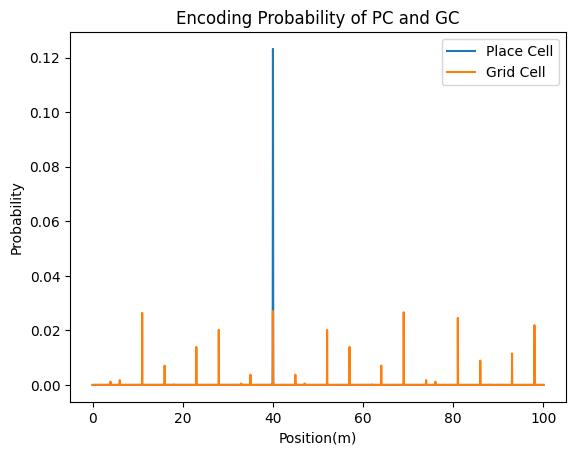

In [72]:
# plot the probability of place cell and grid cell in the same figure for comparison
plt.figure()
plt.plot(pos_candidate.detach().numpy(), prob_pos_p.detach().numpy(), label='Place Cell')
plt.plot(pos_candidate.detach().numpy(), prob_pos_g.detach().numpy(), label='Grid Cell')
plt.legend()
plt.title('Encoding Probability of PC and GC')
plt.xlabel('Position(m)')
plt.ylabel('Probability')
plt.show()

In [73]:
# get the index of the maximum probability
max_index_g = torch.argmax(prob_pos_g)
print('max_index_g:', max_index_g)
max_index_p = torch.argmax(prob_pos_p)
print('max_index_p:', max_index_p)

max_index_g: tensor(5119)
max_index_p: tensor(5119)


In [74]:
# get the top 10 maximum probability
topk_g = torch.topk(prob_pos_g, 10)
print('topk_g:', topk_g)

topk_g: torch.return_types.topk(
values=tensor([0.0271, 0.0270, 0.0266, 0.0264, 0.0246, 0.0230, 0.0226, 0.0225, 0.0219,
        0.0217]),
indices=tensor([ 5119,  5120,  8831,  1408, 10368, 10369,  1409,  8830, 12542,  8832]))
